<a href="https://colab.research.google.com/github/andrebelem/pymhw/blob/main/Teste_Marine_Heat_Wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd


df = pd.read_csv('https://raw.githubusercontent.com/andrebelem/ASTOC/main/dados_publicos/tupi_sst_mean.csv',decimal=',',sep=';')
df.time = pd.to_datetime(df.time)
df = df.set_index('time')
# não há uma necessidade muito grande de manter neste padrão, mas obviamente você
# terá que adaptar o código abaixo se quiser mudar (por exemplo) os nomes das colunas. Aqui estou usando uma série temporal e vou criar um "gap" para teste

# agora vou criar um gap em 2013 - ou seja, ausência total de dados
df_gap = df[~df.index.year.isin([2013])]

Note que aqui, o dado original também tem dados de temperatura, mas o gap tem um buraco que atrapalharia muito a construção de uma climatologia.

Obviamente, não precisamos que as duas séris sejam da mesma fonte (nesse caso aqui é ERSST V5), mas a climatologia tem que ter mais consistência do que a séria que você vai analisar.

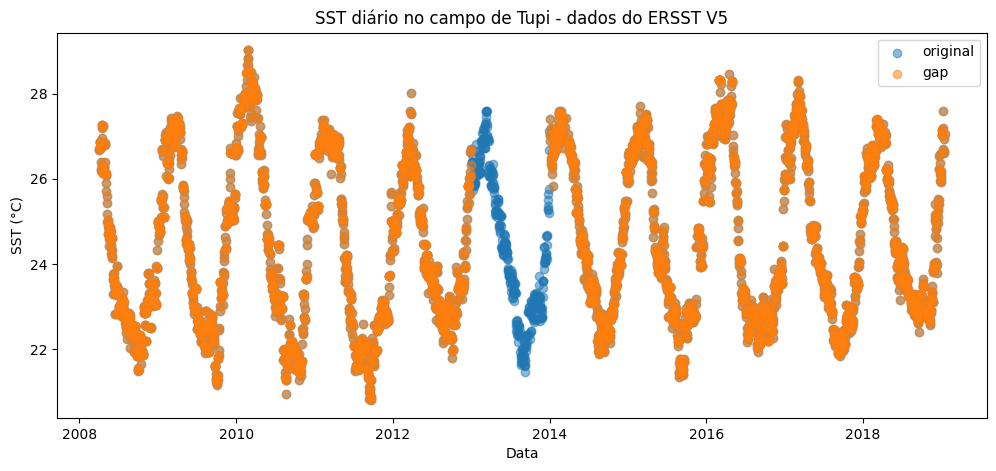

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,5))
plt.scatter(df.index,df.sst,alpha=0.5,label='original')
plt.scatter(df_gap.index,df_gap.sst,alpha=0.5,label='gap')
plt.xlabel('Data')
plt.ylabel('SST (°C)')
plt.title('SST diário no campo de Tupi - dados do ERSST V5')
plt.legend()
plt.show()

A estratégia é construir um dataframe que contenha a climatologia de um período conhecido. Vou obter nesta série a climatologia entre 2008 e 2013 (5 anos) para ter valores de desvio padrão consistentes. Considere no seu exemplo que sua climatologia deveria ter ao menos 30 anos e **pode ser feita com base no ERSST V5**.

In [7]:
df.index.year

Index([2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008,
       ...
       2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
      dtype='int32', name='time', length=3876)

In [19]:
# aqui monta a climatilogia entre 2008 e 2014 "inclusive" **Isso é um teste**

# passo 1 - limito o pedíodo e retiro o timeindex
clima = df[(df.index.year >= 2008) & (df.index.year <= 2013)].reset_index()

# passo 2 - cria uma coluna reagrupando por dayofyear
df_clima =  clima.groupby(clima.time.dt.dayofyear).agg(['mean','std']).iloc[:,[2,3]]

# note que o resultado é uma climatologia que contém no index "time" (dayofyear 1-366) e "std"
df_clima

sst          
           mean       std
time                     
1     25.852856  0.872301
2     25.941428  0.995596
3     26.050000  1.173561
4     25.987143  1.083333
5     25.964286  1.112119
...         ...       ...
362   25.345239  1.149124
363   25.382859  1.202322
364   25.659525  1.023365
365   25.922620  1.019910
366   25.857143  1.191983

[366 rows x 2 columns]

In [57]:
df_clima.columns


MultiIndex([('sst', 'mean'),
            ('sst',  'std')],
           )

Agora o passo seguinte é aplicar a climatologia na série e extrair as MHW e seus respectivos índices e parâmetros.

In [62]:
import pandas as pd
import numpy as np

def detect_MHW(df, df_clima, freq='1D'):
    # Faz uma cópia do DataFrame para garantir que o original não será modificado
    df2 = df.copy()
    df2_clima = df_clima.copy()

    # Verifica se o índice é um DatetimeIndex
    if not isinstance(df2.index, pd.DatetimeIndex):
        try:
            df2.index = pd.to_datetime(df2.index)
        except Exception as e:
            raise ValueError("O índice não pode ser convertido para DatetimeIndex.") from e

    # Gera um índice regular esperado com base na frequência fornecida
    expected_index = pd.date_range(start=df2.index.min(), end=df2.index.max(), freq=freq)

    # Reindexa o DataFrame para garantir que ele esteja regular
    df2 = df2.reindex(expected_index)

    # Calcula as diferenças de tempo entre as entradas do índice original
    time_diffs = df.index.to_series().diff().dropna()

    # Calcula a moda das diferenças de tempo
    dominant_freq = time_diffs.mode()[0]

    # Compara a frequência dominante com a frequência esperada
    expected_freq = pd.Timedelta(freq)
    if dominant_freq != expected_freq:
        raise ValueError(f"A frequência dominante dos dados ({dominant_freq}) não corresponde à frequência esperada ({expected_freq}).")

    # Estatísticas adicionais
    start_date = df2.index.min()
    end_date = df2.index.max()
    num_points = len(df2)
    num_nans = df2.isna().sum().sum()  # Número total de NaNs
    percent_nans = (num_nans / df2.size) * 100  # Percentual de NaNs

    # Impressão das estatísticas
    print(f"Série de {start_date} até {end_date}")
    print(f"Frequência dominante: {dominant_freq}")
    print(f"Número de pontos: {num_points}")
    print(f"Número de NaNs: {num_nans}")
    print(f"Percentual de NaNs: {percent_nans:.2f}%")

    # retira o time de index e insere dayofyear
    df2 = df2.reset_index().rename(columns={'index':'time'})
    df2['dayofyear'] = df2.time.dt.dayofyear

    # calcula a anomalia e compara com std
    df2['anomaly'] = df2.apply(lambda row: row['sst'] - df_clima.loc[row['dayofyear'], ('sst', 'mean')], axis=1)
    df2['zscore'] = df2.apply(lambda row: row['anomaly']/df_clima.loc[row['dayofyear'], ('sst', 'std')], axis=1)

    # Identificar períodos onde o zscore é maior que 1
    df2['above_1'] = df2['zscore'] > 1

    return df2

In [64]:
def calculate_mhw_periods(df2):
    # Identificar as durações dos períodos em que o zscore é maior que 1
    df2['mhw_id'] = (df2['above_1'] != df2['above_1'].shift()).cumsum()
    mhw_periods = df2[df2['above_1']].groupby('mhw_id').agg(
        start=('time', 'min'),
        end=('time', 'max'),
        duration=('time', 'count'),
        max_zscore=('zscore', 'max')
    ).reset_index(drop=True)

    # Definir graus de intensidade com base no zscore
    mhw_periods['intensity'] = mhw_periods['max_zscore'].apply(lambda x: int(min(max(x, 1), 5)))

    return mhw_periods

In [65]:
df_temp = detect_MHW(df,df_clima)

Série de 2008-04-02 00:00:00 até 2019-01-16 00:00:00
Frequência dominante: 1 days 00:00:00
Número de pontos: 3942
Número de NaNs: 66
Percentual de NaNs: 1.67%


In [68]:
mhw = calculate_mhw_periods(df_temp)
mhw

,start,end,duration,max_zscore,intensity
0,2008-04-15,2008-04-19,5,1.326733,1
1,2008-04-28,2008-05-01,4,1.600517,1
2,2008-05-03,2008-05-05,3,1.542270,1
3,2008-05-23,2008-05-25,3,1.433708,1
4,2008-05-31,2008-05-31,1,1.030595,1
...,...,...,...,...,...
151,2018-12-20,2018-12-27,8,1.596984,1
152,2019-01-02,2019-01-02,1,1.206749,1
153,2019-01-06,2019-01-08,3,1.872525,1
154,2019-01-10,2019-01-10,1,1.092310,1


Agora vamos graficar um pouco

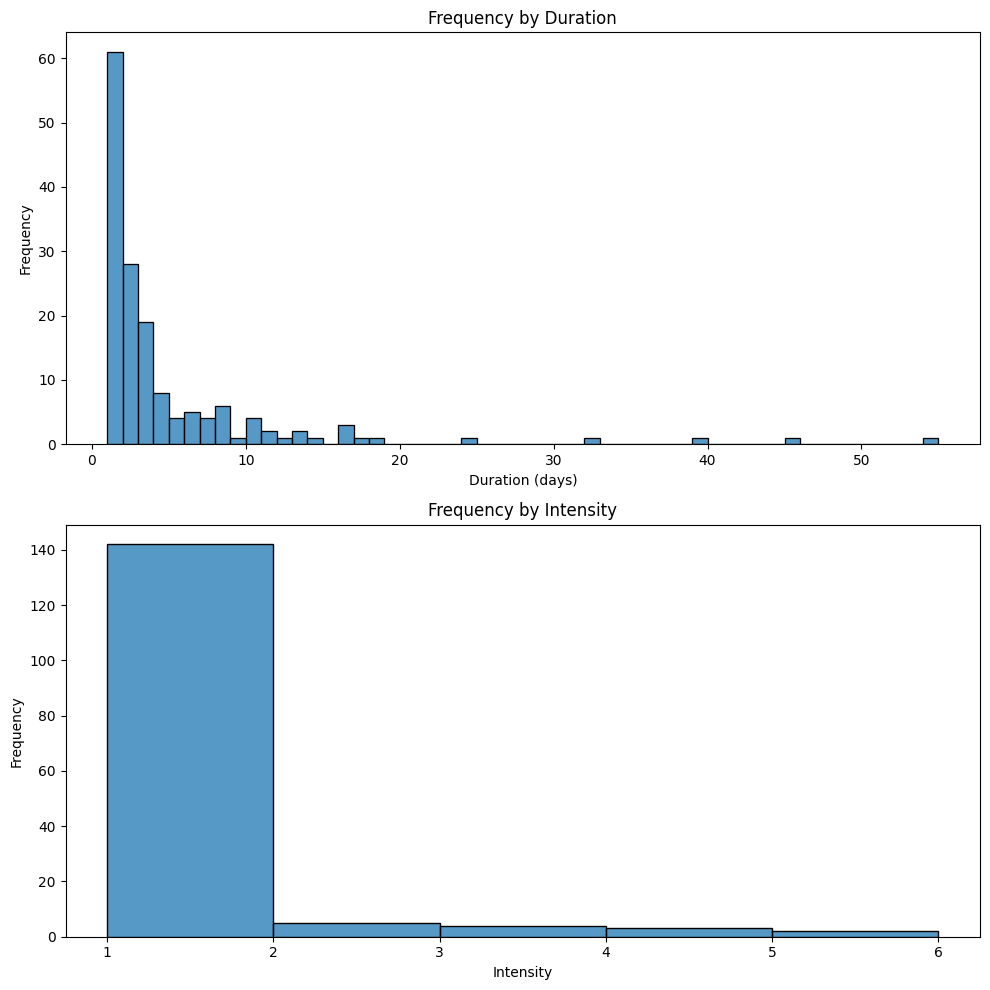

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Funções anteriores aqui...

# lembrando que  que df e df_clima são seus DataFrames já carregados
# df_temp = detect_MHW(df, df_clima)
# mhw = calculate_mhw_periods(df_temp)

# Criar histogramas combinados
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Histograma de frequência por duração
sns.histplot(mhw['duration'], bins=range(1, mhw['duration'].max() + 2), kde=False, ax=ax[0])
ax[0].set_title('Frequency by Duration')
ax[0].set_xlabel('Duration (days)')
ax[0].set_ylabel('Frequency')

# Histograma de frequência por intensidade
sns.histplot(mhw['intensity'], bins=range(1, mhw['intensity'].max() + 2), kde=False, ax=ax[1])
ax[1].set_title('Frequency by Intensity')
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Frequency')

# Ajustar layout
plt.tight_layout()
plt.show()
